# Cyber bullying Tweet Detection

## Dataset

* **tweet_text:** This contains all the text written in the tweet.

* **cyberbullying_type:** 6 different classes:
  * Age
  * Ethnicity
  * Gender
  * Religion
  * Other type of cyberbullying
  * Not cyberbullying


In [25]:
#Importing relevant libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [26]:
import pandas as pd
df = pd.read_csv("/kaggle/input/cyberbullying-classification/cyberbullying_tweets.csv")

In [27]:
df.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


In [28]:
df.sample(5)

,tweet_text,cyberbullying_type
44289,"“@InkUp4Lyfe “@tayyoung_ FUCK OBAMA, dumb ass ...",ethnicity
26059,@MrTheGeoff no case file would ever be publicl...,other_cyberbullying
35665,"Never let them see you Sw... oh hell, you’re w...",age
23534,@NicolaSturgeon nippy lied people died. you ti...,religion
29344,When I go home I'm watching cartoons with my b...,other_cyberbullying


**Check No of rows and columns**

In [29]:
df.shape

(47692, 2)

**Check for Missing Values**

In [30]:
df.isnull().sum()

tweet_text            0
cyberbullying_type    0
dtype: int64

**Check for Duplicate values**

In [31]:
df.duplicated().sum()

36

**Drop Duplicate values**

Since no of duplicate values are significanly less compared to whole dataset, so we can directly drop them

In [32]:
df.drop_duplicates(subset='tweet_text',keep='first',inplace=True)

## Explanatory Data Analysis (EDA)

**1. Cyber Bullying type**

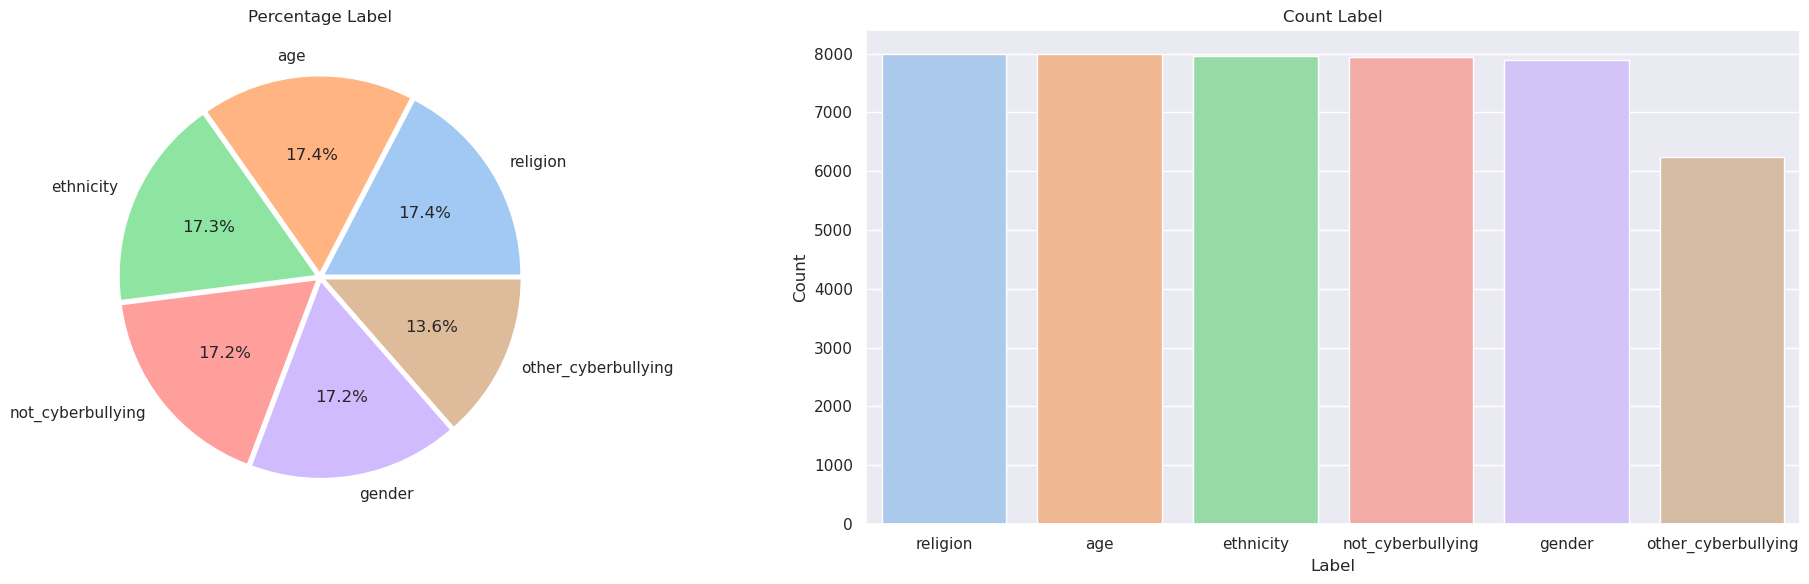

In [33]:
#Value Label Count
label_count = df['cyberbullying_type'].value_counts()
fig,axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))

#Set Vusualization
sns.set_theme(style='darkgrid', palette='pastel')
color = sns.color_palette(palette='pastel')
explode = [0.02]*len(label_count)

#Pie
axes[0].pie(label_count.values, labels=label_count.index, autopct='%1.1f%%', colors=color, explode=explode)
axes[0].set_title('Percentage Label')

#Bar
sns.barplot(x=label_count.index, y=label_count.values, ax=axes[1])
axes[1].set_title('Count Label')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

#Show
plt.tight_layout()
plt.show()

We can observe that the dataset is somewhat balanced

**2. Examine the distribution of sentence length for each type of bullying.**

Text(0.5, 0, 'Length of tweet')

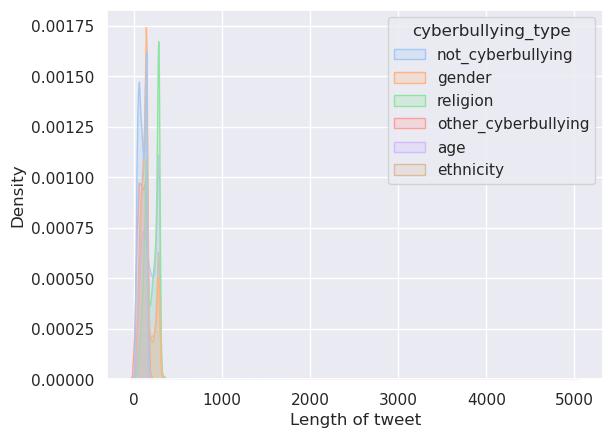

In [34]:
df['length'] = df['tweet_text'].apply(len)
df.head()

# Plot Distribution length words
#density plot
sns.kdeplot(df,x=df['length'],hue='cyberbullying_type',fill=True)
plt.xlabel('Length of tweet')

# Data Cleaning

In [35]:
import string
import re
import nltk


def clean_data(text):
  text = text.lower() #converts all characters in the text variable to lowercase
  text = re.sub(r'@\S+',"",text) #This pattern is commonly used to remove Twitter usernames or any other mentions in the text.
  text = re.sub(r'http\S+','',text)#This pattern is typically used to remove URLs or links from the text.
  text = re.sub(r'pic.\S+','',text) #This pattern is often used to remove picture links or references.
  text = re.sub(r'\d+',"",text)# removes any sequences of one or more digits from the text
  text = re.sub(r"[^a-zA-Z']",' ',text) # It effectively removes any non-alphabetic characters from the text.
  text = re.sub(r"\s+[a-zA-Z]\s+"," ",text+" ") # remove isolated single letters that may not provide meaningful information.
  text = ''.join([i for i in text if i not in string.punctuation]) #It removes all punctuation marks from the text.
  return text

df['new_text'] = df['tweet_text'].apply(clean_data)

In [36]:
print(df.iloc[3])

tweet_text            @Jason_Gio meh. :P  thanks for the heads up, b...
cyberbullying_type                                    not_cyberbullying
length                                                              103
new_text               meh thanks for the heads up  but not too conc...
Name: 3, dtype: object


# CountVectorizer
**Vocabulary creation: CountVectorizer constructs a vocabulary by collecting all unique tokens from the tokenized text. Each token is assigned a unique index in the vocabulary.**

In [37]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer()
matrix = cv.fit_transform(df['new_text'])
word_matrix = pd.DataFrame(matrix.toarray(),columns=cv.get_feature_names_out())

In [38]:
outputs = matrix.toarray()
outputs[100:105,190:200]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

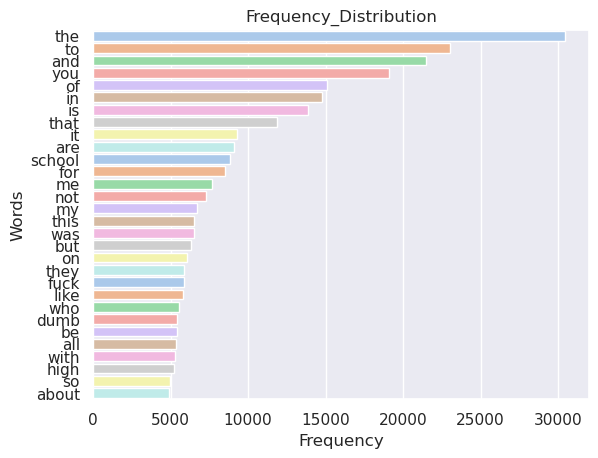

In [39]:
df_sum = word_matrix.sum(axis=0,skipna=True) #sum words
bow = df_sum.sort_values(ascending=False)[:30] ## Top 30 word frequency and Sorted
bow = pd.DataFrame(bow,columns=['Frequency'])


#Visualization
sns.barplot(x=bow['Frequency'], y=bow.index, palette='pastel')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Frequency_Distribution')
plt.show()

## Wordcloud
**Look at the most common words in Cyber bully text that each type**

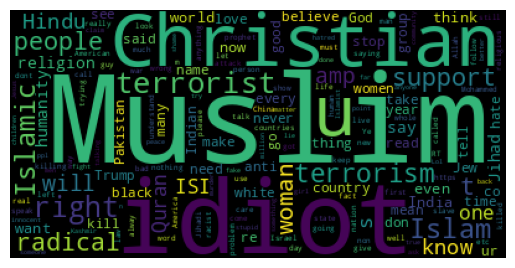

In [40]:
from wordcloud import WordCloud
def create_cloud(data):
  text = df[df['cyberbullying_type']==data]
  text_cloud = " ".join(txt for txt in text['tweet_text'])
  cloud = WordCloud(collocations=False, background_color='black').generate(text_cloud)
  plt.imshow(cloud)
  plt.axis('off')
create_cloud('religion')

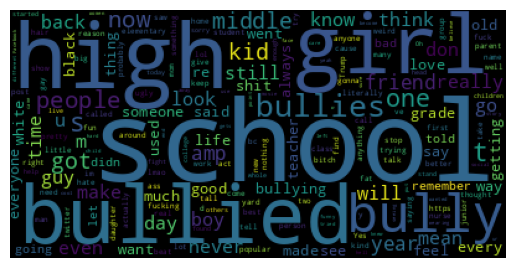

In [41]:
create_cloud('age')

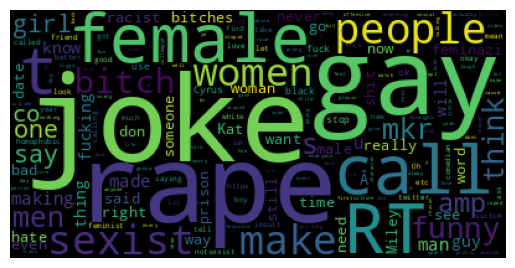

In [42]:
create_cloud('gender')

# Model Building and Training

In [43]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score ,classification_report


x = df['tweet_text']
#encode for train
y,class_names = pd.factorize(df['cyberbullying_type'],sort=True)


#split train & test
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=0)

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(36813,)
(9204,)
(36813,)
(9204,)


## MutlinomialDB from Naive Bayes

In [46]:
from sklearn.naive_bayes import MultinomialNB
pipe1 = Pipeline([('vectorizer',TfidfVectorizer()),
                  ('classifier',MultinomialNB())])
pipe1.fit(x_train,y_train)
y_pred = pipe1.predict(x_test)
print('Accuracy:{:.3f}'.format(accuracy_score(y_test,y_pred))

Accuracy:0.883


## Logistic Regression

In [50]:
from sklearn.linear_model import LogisticRegression
pipe2 = Pipeline([('vectorizer',TfidfVectorizer()),
                  ('classifier',LogisticRegression())])
pipe2.fit(x_train,y_train)
y_pred = pipe2.predict(x_test)
print('Accuracy:{:.3f}'.format(accuracy_score(y_test,y_pred)))

Accuracy:0.926


## Random Forest

In [51]:
from sklearn.ensemble import RandomForestClassifier
pipe3 = Pipeline([('vectorizer',TfidfVectorizer()),
                  ('classifier',RandomForestClassifier())])
pipe3.fit(x_train,y_train)
y_pred = pipe3.predict(x_test)
print('Accuracy:{:.3f}'.format(accuracy_score(y_test,y_pred)))

Accuracy:0.951
